# Modelling continuous data with Tensoflow Probability

In this notebook you will learn how work with TFP. You will set up linear regression models that are able to output a gaussian conditional probability distribution. You will define different models with Keras and the Tensorflow probability framework and optimize the negative log likelihood (NLL). You will model the conditional probability distribution as a Normal distribution with a constant, montonic and flexible standart deviation $\sigma$. The mean $\mu$ of the CPD will always depend linearly on the input. You compare the performace of the 3 models based on the NLL on a validaiton set and use the one with the lowest NLL to predict the test set. Finally, you will also do an extrapolation experiment with the best model and look how the predicted CPD behaves.


**Dataset:** 
You work with a simulated dataset that looks a bit like a fish when visualized in a scatterplot. The data is simulated to have  a linear slope but non-constant variance. The variance starts with a large value then slowly decreases to increase again and in the end it decreases again. You split the data into train, validation and test dataset.

**Content:**
* Work with a Normal distribution in TFP
* Simulate and split the dataset 
* Fit a model with keras and TFP that models the CPD with a linear mean $\mu$ and a fixed standart deviation $\sigma$
* Fit a model with keras and TFP that models the CPD with a linear mean $\mu$ and monotoic standart deviation $\sigma$
* Fit a model with keras and TFP that models the CPD with a linear mean $\mu$ and flexible standart deviation $\sigma$ (by adding hidden layers)
* Compare the different models based on the NLL loss on the validation dataset
* Choose one of these model to predict the test dataset and calculate the NLL on the test data
* Make a extrapolation experiment with the best model and look how the predicted CPD behaves



In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
!pip install tensorflow_probability==0.8.0

#### Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp
import tensorflow as tf

%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.8.0
TF  Version 2.1.0


### Working with a TFP Normal distribution

Here you can see how to work with normal distribution in TFP.

In [4]:
import tensorflow_probability as tfp
tfd = tfp.distributions
d = tfd.Normal(loc=3, scale=1.5)           #A
x = d.sample(2) # Draw two random points.    #B
px = d.prob(x) # Compute density/mass.       #C
print(x)
print(px)
#A create a 1D Normal distribution with mean 3 and standard deviation 1.5
#B sample 2 realizations from the Normal distribution
#C compute the likelihood for each of the two sampled values under the defined Normal distribution 

tf.Tensor([7.6395745 2.7025864], shape=(2,), dtype=float32)
tf.Tensor([0.00222526 0.26078466], shape=(2,), dtype=float32)


Further methods for TensorFlow Distributions.

In [5]:
dist = tfd.Normal(loc=1.0, scale=0.1)
print('sample   :', dist.sample(3).numpy()) #Samples 3 numbers
print('prob     :',dist.prob((0,1,2)).numpy()) #Calculates the probabilities for positions 0,1,2
print('log_prob :',dist.log_prob((0,1,2)).numpy()) #Same as above just log
print('cdf      :',dist.cdf((0,1,2)).numpy()) #Calculates the cummulative distributions
print('mean     :',dist.mean().numpy()) #Returns the mean of the distribution
print('stddev   :',dist.stddev().numpy())

sample   : [1.1630603 1.0000321 1.1402246]
prob     : [7.6946093e-22 3.9894230e+00 7.6946093e-22]
log_prob : [-48.616352    1.3836466 -48.616352 ]
cdf      : [7.619853e-24 5.000000e-01 1.000000e+00]
mean     : 1.0
stddev   : 0.1


#### Exercise:
Define Normal distribution with mu = 5 and sigma = 1.2 and caluculate the probability density/mass function for the values 0, 0.1, 0.2, 0.3, ..., 10.  
Do the same for a Poisson distribution with rate = 5 for the values 0, 1, 2, ..., 10*Hint:  tfd.poisson.Poisson().*  
Plot the results  

sample   : [4.9565687 3.699943  5.915155 ]
prob     : [5.6469184e-05 7.9634381e-05 1.1152528e-04 1.5510649e-04 2.1422545e-04
 2.9383000e-04 4.0022563e-04 5.4137467e-04 7.2723546e-04 9.7014493e-04
 1.2852326e-03]


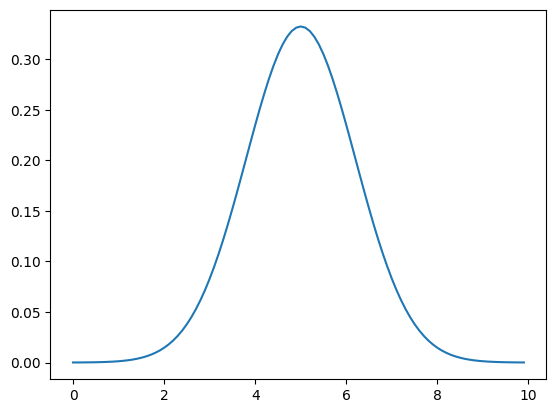

sample   : [6. 6. 3.]
prob     : [0.00673795 0.03368974 0.08422434 0.1403739  0.17546739 0.17546739
 0.14622283 0.10444485 0.06527807 0.03626555 0.0181328 ]


In [8]:
### Your code here

# Normal distribution
mydist = tfd.Normal(loc=5.0, scale=1.2)
print('sample   :', mydist.sample(3).numpy()) #Samples 3 numbers
print('prob     :', mydist.prob((0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0)).numpy()) #Calculates the probabilities for positions 0,1,2
plt.plot(np.arange(0,10,0.1),mydist.prob(np.arange(0,10,0.1)))
plt.show()

# Poisson distribution
mypdist = tfd.poisson.Poisson(rate=5.0)
print('sample   :', mypdist.sample(3).numpy()) #Samples 3 numbers
print('prob     :', mypdist.prob((0,1,2,3,4,5,6,7,8,9,10)).numpy()) #Calculates the probabilities for positions 0,1,2
#plt.plot()
#plt.show()


### Simulate the fishlike data

In the next few cells you will simulate some (x,y)-data where the y increases on average linerly with x but has non-constant variance that so that scatterplot looks like a fish.You will fist simulate random distributed noise with non constant variance, then uniformly distributed x values between -1 and 6 and finally calculate corresponding y values with y = 2.7*x+noise (linear slope of 2.7 and intercept of 0). The variance of the noise will change, it starts with a high value of 12 and gets smaller until it is reaches a constant value of 1, then it grows again until a value of 15 to stay constant for a while and to decrease to 1 again. Look at the plot to understand the behavior of the variance. 

In [0]:
### define variance structure of the simulation
x1=np.arange(1,12,0.1)
x1=x1[::-1]
x2=np.repeat(1,30)
x3=np.arange(1,15,0.1)
x4=np.repeat(15,50)
x5=x3[::-1]
x6=np.repeat(1,20)
x=np.concatenate([x1,x2,x3,x4,x5,x6])
plt.plot(x)
plt.xlabel("index",size=16)
plt.ylabel("sigma",size=16)#pred
plt.show()


Now you will sample uniformly distributed x values in the range from -1 to 6. You will sample less x values in the range from -1 to 1. Finally you sort the x values (for ploting reasons). 

In [0]:
# generation the x values for the simulated data
np.random.seed(4710)
noise=np.random.normal(0,x,len(x))
np.random.seed(99)
first_part=len(x1)
x11=np.random.uniform(-1,1,first_part)
np.random.seed(97)
x12=np.random.uniform(1,6,len(noise)-first_part)
x=np.concatenate([x11,x12])
x=np.sort(x)

Let's put it all together to make the simulated fishlike data complete. You calculate y from the x values and the noise with a linear function where the slope is 2.7 and the intercept is 0, y=2.7*x+noise.  

In [0]:
## generation the y values for the simulated noise and the x values
y=2.7*x+noise

In [0]:
y=y.reshape((len(y),1))
x=x.reshape((len(x),1))

In [0]:
# lets visualize the data
plt.scatter(x,y,color="steelblue") 
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)#pred
plt.show()

#### Split data in train and test

In the next cells you will spilt the data x and y into a training, validation and test set. To get a first train and test dataset you just randomly sample 25% of the x and y values in the test dataset and the rest is the training dataset. The resulting training dataset gets splitted again into a training and validation dataset (80% training and 20% validation). After the splitting of the dataset you need to make sure that all the x values  from every dataset are in increasing order for ploting reasons (note that you also need to reorder the corresponding y values for all datasets).

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=47)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=22)

print("nr of traning samples = ",len(x_train))
print("nr of validation samples = ",len(x_val))
print("nr of test samples = ",len(x_test))


In [0]:
## reordering so x values are in increasiong order
order_idx_train=np.squeeze(x_train.argsort(axis=0))
x_train=x_train[order_idx_train]
y_train=y_train[order_idx_train]

order_idx_val=np.squeeze(x_val.argsort(axis=0))
x_val=x_val[order_idx_val]
y_val=y_val[order_idx_val]

order_idx_test=np.squeeze(x_test.argsort(axis=0))
x_test=x_test[order_idx_test]
y_test=y_test[order_idx_test]


Let's plot the training and validation data. You can see that it really looks a bit like a fish. In the following cells you will train different models on the training data, validate the loss (NLL) on the validation data and in the end you will predict the testdata with the best model. It's important to keep the testdata in a locked safe, because in practice it is unknown, until you decide which model you want to use to make a prediction. That is the reason why you will plot it only in the end.


In [0]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])


plt.subplot(1,2,2)
plt.scatter(x_val,y_val,facecolors='none', edgecolors="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

In [0]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Fit a linear regression model with constant variance
In the next cells you will define and fit a linear model on the simulated fish data with keras. You define a simple linear regression NN with only two parameters to model the output as a gaussian conditional probability distribution , for the loss we use the mse.

In [0]:
inputs = Input(shape=(1,))
params = Dense(1)(inputs) #B

model_ = Model(inputs=inputs, outputs=params)
model_.compile(Adam(learning_rate=0.01), loss="mse") 

In [0]:
model_.summary()

In [0]:
history = model_.fit(x_train, y_train, epochs=3000, verbose=0, validation_data=(x_val,y_val))

To calculate the  minimal NLL we need to know the optimal constant sigma that minimizes the NLL. To get the optimal sigma we use the formulat for the optimal signma and compute a slightly adjusted standart deviation of the residuals.

In [0]:
preds_train = model_.predict(x_train)
preds_val = model_.predict(x_val)

SSR= np.sum(np.square(y_train-preds_train))
sigma_=np.sqrt((SSR)/(len(x_train)-2))
sigma_

To calculate the NLL with the optimal constant sigma, you can use the formula for the $$NLL = \frac{1}{n}\sum_{i=1}^{n}- log(\frac{1}{\sqrt{2 \pi \sigma^2_x}})+\frac{(y_i - \mu_i)^2}{2 \sigma^2_x}$$ 


In [0]:
#loss with the estimated sigma
NLL_train=np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(sigma_))))+
                  ((np.square(y_train-model_.predict(x_train))/(2*np.square(sigma_)))))
print(NLL_train)
NLL_val=np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(sigma_))))+
                ((np.square(y_val-model_.predict(x_val))/(2*np.square(sigma_)))))
print(NLL_val)

Now you will plot the trained model with the resulting mean and +-2 sigma at each x value and see how well it fits the data. Remember in this model you used a linear model for the mean of the CPD and just fixed the standart deviation sigma to a constant value.

In [0]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_.predict(x_pred)
sigma = sigma_
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

## Fit a linear regression model and allow the sd to depend in a monotonic way on the input

Let's try to model the standart deviation sigma in a monotonic way. To define a monotonic standart deviation, you can use a Normal distribution in TFP and you fit both parameters the mean and sigma. You don't use any hidden layers in between. As loss function we use the NLL.

In [0]:
def NLL(y, distr):
  return -distr.log_prob(y) #A

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable #C #D

inputs = Input(shape=(1,))
params = Dense(2)(inputs) #B
dist = tfp.layers.DistributionLambda(my_dist)(params) #C #D

model_monotoic_sd = Model(inputs=inputs, outputs=dist)
model_monotoic_sd.compile(Adam(learning_rate=0.01), loss=NLL) 

#A Define NLL of the model 
#B Setting up the NN with two output node
#C The first output node defines the mean (loc)
#D The second output defines the standard deviation (scale) via the softplus function 

In [0]:
model_monotoic_sd.summary()

In [0]:
history = model_monotoic_sd.fit(x_train, y_train, epochs=3000, verbose=0, validation_data=(x_val,y_val))

In the next cell you define two models to predict the mean $\mu$ and the standart deviation $\sigma$ of the output distribution.

In [0]:
model_monotoic_sd_mean = Model(inputs=inputs, outputs=dist.mean())
model_monotoic_sd_sd = Model(inputs=inputs, outputs=dist.stddev())

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

#### Result:  monotonic sigma

In [0]:
print(model_monotoic_sd.evaluate(x_train,y_train, verbose=0))
print(model_monotoic_sd.evaluate(x_val,y_val, verbose=0))

In [0]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_monotoic_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

Now that you have trained and ploted the model with the resulting mean and +-2  sigma at each x value you see how well it fits the data.You see that the standart deviation is not constant but increases with bigger x-values - this is still not describing the data variance very well. The mean of the distribution is still linear because there are no hidden layers in this model. Even if this model is more complex than the ones before, the NLL on the validation set with ~3.5 is unfortunately a bit higher compared to the model with the estimated constant sigma, which had a NLL of ~3.5. The main reason for this is because the simulated variance is not monotonic.

## Fit a linear regression and allow the sd to depend in a flexible manner on the input

From the model with the monotonic standart deviation you probability guessed that you need a model where the standart deviation sigma is non-linear and able to increase for some x-values but then agian decrease for others. Remeber how the data was simulated. Let's try that and see if we can decrease the NLL below ~3.5. You will now, define and fit a model that models the mean of the normal distribution linearly (no hidden layer for the mean parameter) but for the standart devation sigma, you will use 3 hidden layers in beetween (with 50 ,100  and 50 nodes). Because of the hidden layers the resulting stadart deviation is now able to change non-linarly with x, if necessary. You will use again TFP and keras for the model defintion. The loss function you use again the NLL.

In [0]:
def NLL(y, distr):
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(1,))
out1 = Dense(1)(inputs) #A
hidden1 = Dense(50,activation="relu")(inputs)
hidden1 = Dense(100,activation="relu")(hidden1)
hidden2 = Dense(50,activation="relu")(hidden1)
out2 = Dense(1)(hidden2) #B
params = Concatenate()([out1,out2]) #C
dist = tfp.layers.DistributionLambda(my_dist)(params) 

model_flex_sd = Model(inputs=inputs, outputs=dist)
model_flex_sd.compile(Adam(learning_rate=0.004), loss=NLL)
#A The first output models the mean, no hidden layers are used
#B The second output models the spread of the distribution. Three hidden layers are used for it
#C Combining the outputs for the mean and the spread

In [0]:
model_flex_sd.summary()

In [0]:
history = model_flex_sd.fit(x_train, y_train, epochs=2000, verbose=0, validation_data=(x_val,y_val))

In [0]:
model_flex_sd_mean = Model(inputs=inputs, outputs=dist.mean())
model_flex_sd_sd = Model(inputs=inputs, outputs=dist.stddev())

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.ylim(2,6)
plt.show()

#### Result: flexible sigma 

In [0]:
print(model_flex_sd.evaluate(x_train,y_train, verbose=0))
print(model_flex_sd.evaluate(x_val,y_val, verbose=0))

In [0]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_flex_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

Now that you have trained and ploted the model with the resulting mean and +-2  sigma at each x value you see how well it fits the data. It looks really nice, just like a fish and exacly how we simulated the data. You see that the standart deviation is not constant but depends in a non-linear fashion on x. The mean still still depends linearly on x, constrained by the model, which has no hidden layer between x and the mean-output node. If you look at the NLL on the validation dataset you see that it really is lower than ~3.5, it now is only ~3.1. So with this more complex model you get the lowest NLL on the  the validation set!

### Prediction of the test with the best model
#### Exercise:
Which of the three fitted models shows the best prediction performance on new unseed data? Use the three fitted models to predict the test set and calculate the corresponding test NLL. What value do you expect for the test NLL? Does the observed test NLL meet your expectation?

In [0]:
# Write your code here

### Prediction outside the training x range

#### Optinal Exercise: Do a little extrapolation experiment: Use the model that was trained on data with x-values between -1 and 6 to predicht the mean and sigma of the outcome y for a x-values in the range from -5 to 10. What do you observe?

In [0]:
# Write your code here